# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [279]:
#use this cell to import additional libraries or define helper functions
!pip install scikit-learn



[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [280]:
#Load your data into a pandas dataframe here
df = pd.read_csv("C:\\Users\\USER\\Downloads\\household_power_clean.csv")
df.head()




,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [281]:

import pandas as pd
import datetime as dt

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = (df['Datetime'] - dt.datetime(1970,1,1)).dt.total_seconds().astype(int)
df.head()



,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the prediction horizon or the length of time into the future we want to make predictions for. It is set to be 5 minutes. 
   mu is the forgetting factor or the weight given to past observations relative to current observations. It determines the rate at which the influence of past observations decays over time. A larger value of mu gives more weight to past observations, while a smaller value gives more weight to current observations. In the below code mu is set to be 0.9.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [282]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)
ph = 5

# Calculate ph_index based on the resolution of the time column
resolution = 1
ph_index = int(ph / resolution)


mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: With mu=0.9, the weight given to the first data point will be (1-mu) * mu ** (n_s-2), where n_s-2 is the number of intervals between the first and last data points in the limited dataset, excluding the last point.

In this case, n_s-2 = 4998, so the weight given to the first data point will be (1-0.9) * 0.9 ** 4998, which is approximately 4.4e-08. This weight is quite small, so the contribution of the first data point to the last prediction will be negligible.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [284]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp

  
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

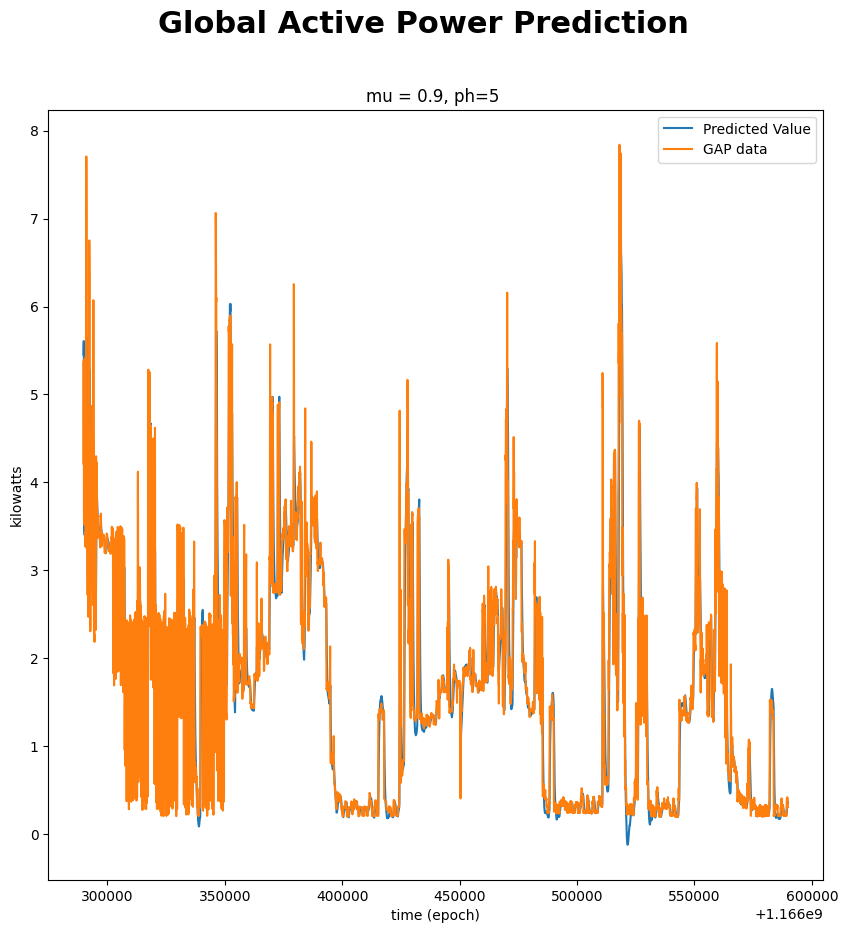

In [285]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

# ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

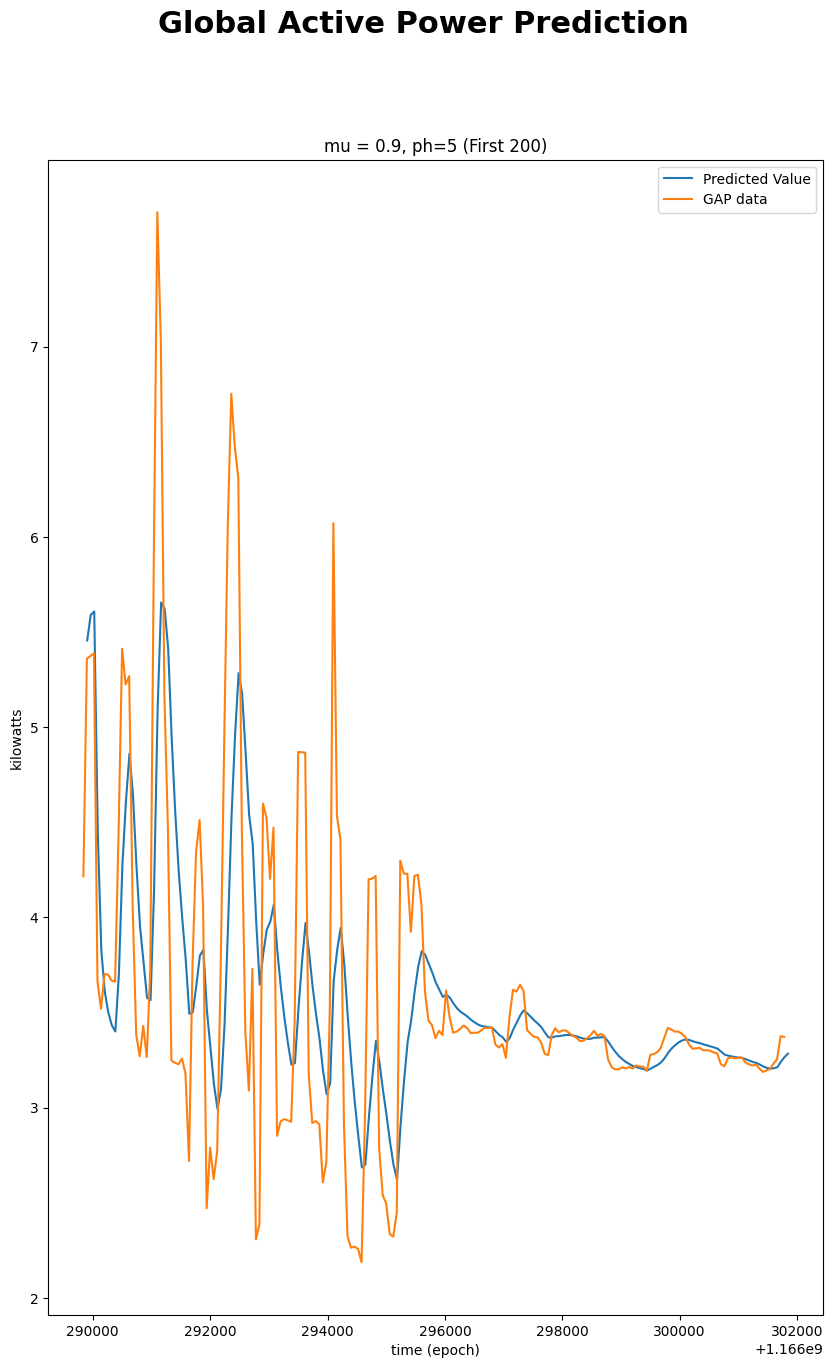

In [286]:
#Plot first 200 data points/predictions

fig, ax1 = plt.subplots( figsize=(10,15))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

ax1.set_title('mu = %g, ph=%g (First 200)' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()


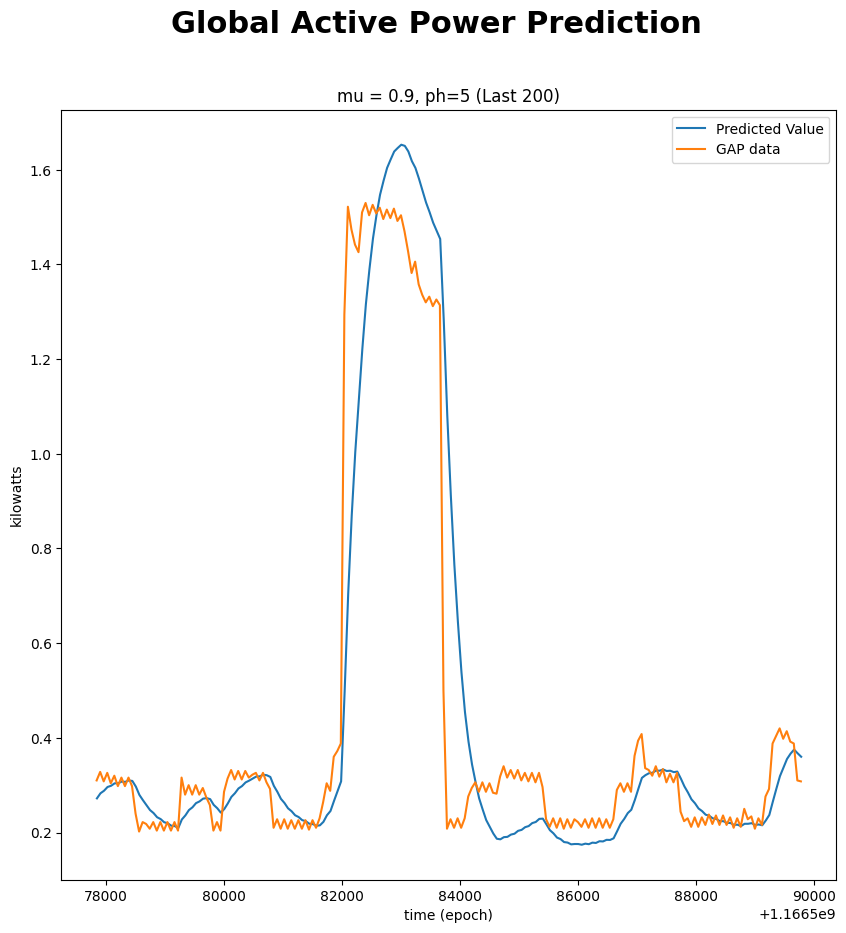

In [287]:
#Plot last 200 data points/predictions
fig, ax2 = plt.subplots(figsize=(10,10))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g (Last 200)' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 

# ax.plot(ts.iloc[n_s-300:n_s,0], ys.iloc[n_s-300:n_s,0], label='CGM data') 
# ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax2.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()
plt.show()







In [289]:
# Calculate MSE of predictions
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE is 0.5227914122680694


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The first chart shows the predicted values and the actual values for the first 200 data points. We can observe that the predicted values are generally following the trend of the actual values. However, there are instances where the predicted values deviate significantly from the actual values.The second chart shows the predicted values and the actual values for the last 200 data points. We can observe that the predicted values seem to be following the trend of the actual values quite well.There seems to be a difference in performance between the early and the late predictions. The early predictions seem to have more deviation from the actual values compared to the later predictions.The MSE Value we got for mu=0.9 and ph=5 is 0.522.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [291]:
mu = 1

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp

  
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

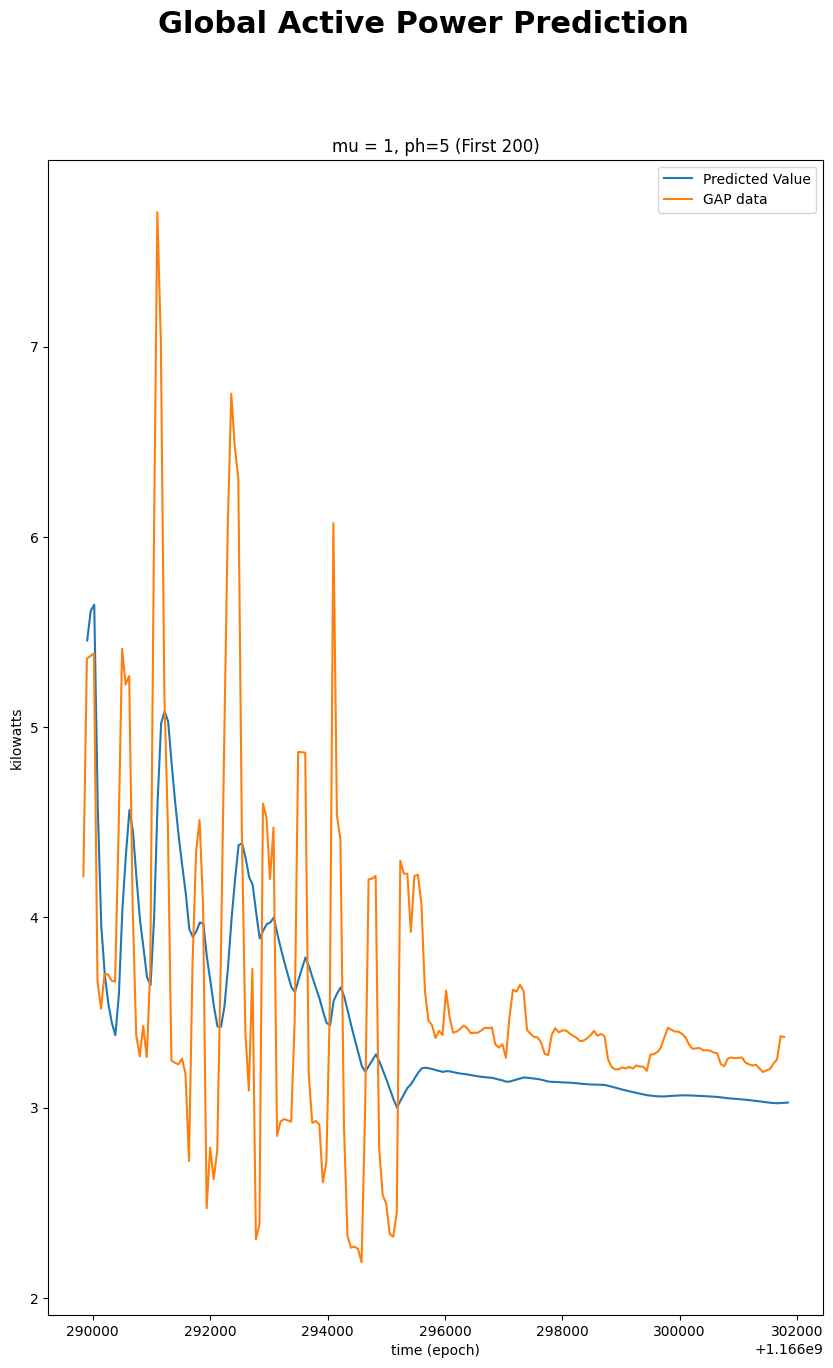

In [293]:
#Plot first 200 data points/predictions for mu = 1
fig, ax1 = plt.subplots( figsize=(10,15))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

ax1.set_title('mu = %g, ph=%g (First 200)' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()
plt.show()

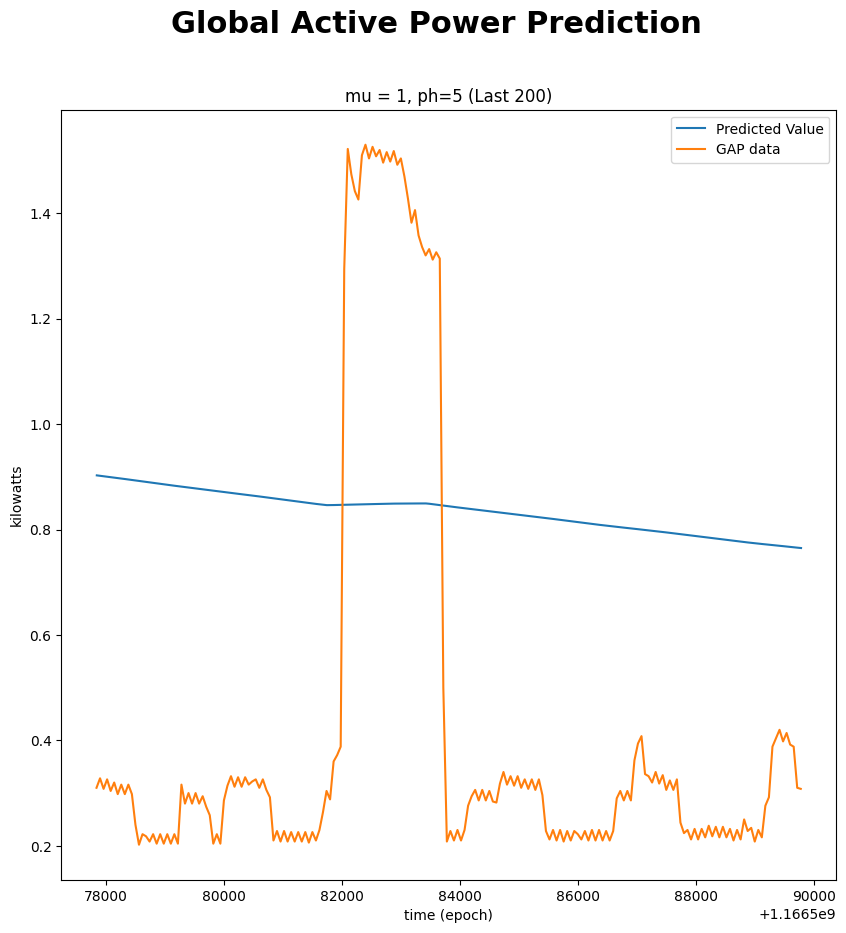

In [263]:
#Plot last 200 data points/predictions for mu = 1
fig, ax2 = plt.subplots(figsize=(10,10))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g (Last 200)' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 

# ax.plot(ts.iloc[n_s-300:n_s,0], ys.iloc[n_s-300:n_s,0], label='CGM data') 
# ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax2.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()
plt.show()

In [295]:
#Calculate MSE of predictions for mu = 1
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.4172641534431427


In [296]:
mu = 0.01

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph
    yp = m_tmp * tp + q_tmp

  
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


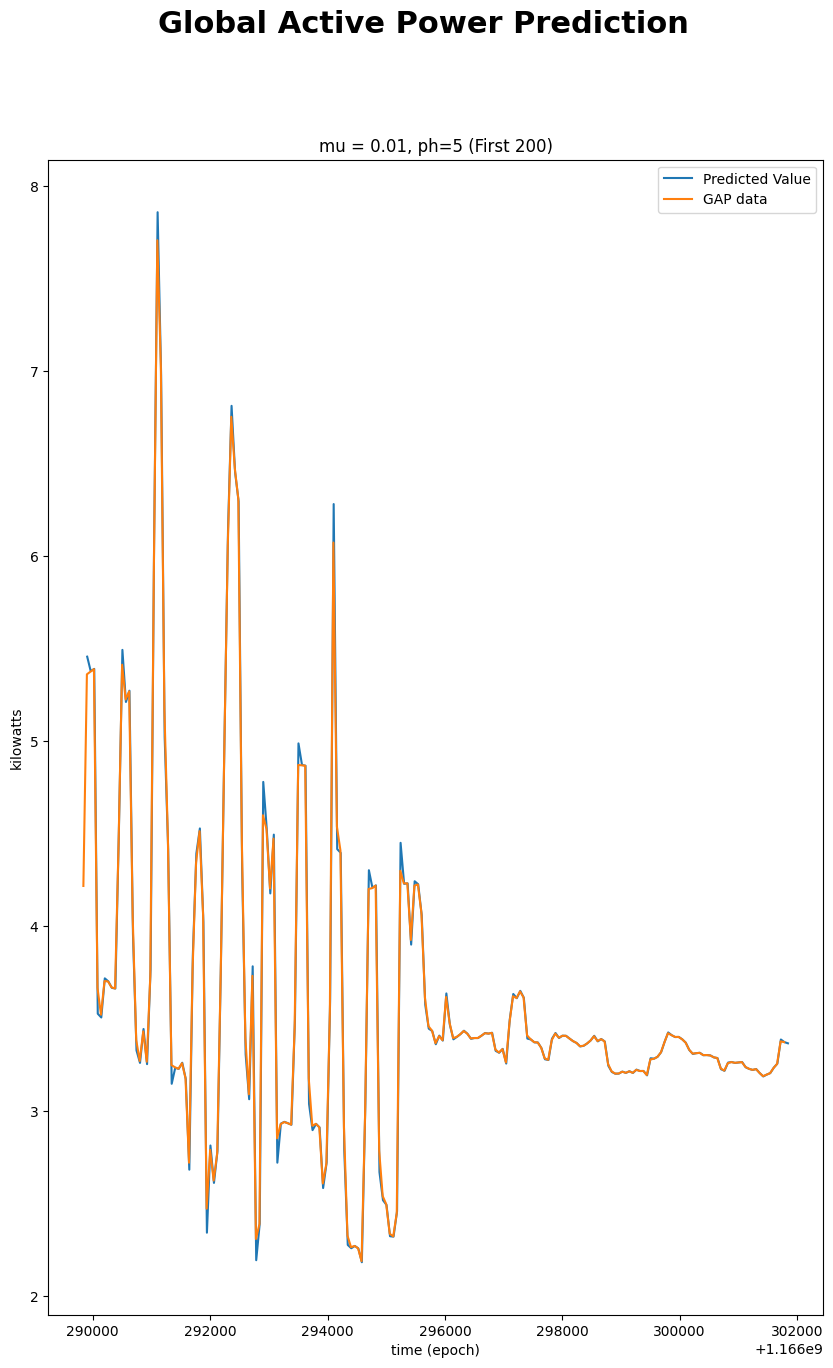

In [298]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax1 = plt.subplots( figsize=(10,15))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

ax1.set_title('mu = %g, ph=%g (First 200)' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()
plt.show()

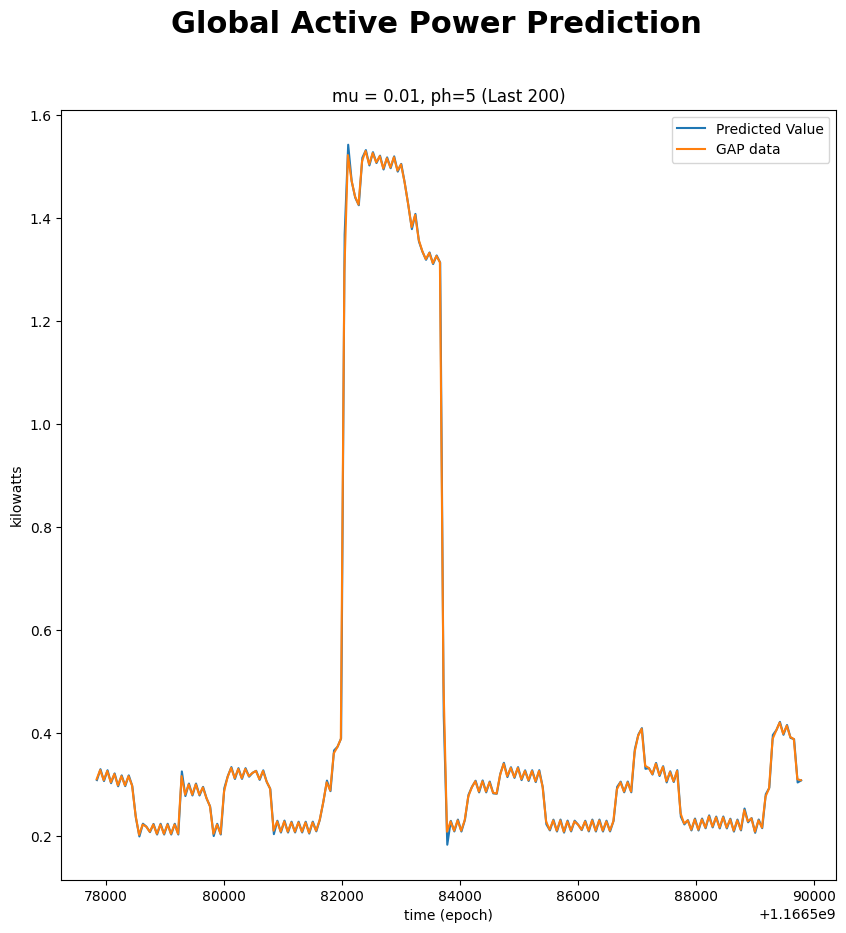

In [300]:
#Plot last 200 data points/predictions for mu = 0.01

fig, ax2 = plt.subplots(figsize=(10,10))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g (Last 200)' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 

# ax.plot(ts.iloc[n_s-300:n_s,0], ys.iloc[n_s-300:n_s,0], label='CGM data') 
# ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax2.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()
plt.show()

In [302]:
#Calculate MSE of predictions for mu = 0.01

from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5954530469730099


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The first chart shows that the predicted values are generally following the trend of the actual values, but there are instances where the predicted values deviate significantly from the actual values.The second chart shows that the predicted values are not following the trend of the actual values very well.
There is a difference in performance between the early and the late predictions. The early predictions seem to have more deviation from the actual values compared to the later predictions.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The first chart shows that the predicted values are following the trend of the actual values quite well, with only a few instances of deviation.The second chart  also shows that the predicted values are following the trend of the actual values quite well.There does not appear to be a significant difference in performance between the early and the late predictions.The MSE value of 0.59 further supports this observation. A lower MSE indicates that the average squared difference between the predicted values and the actual values is smaller, which implies that the mu=0.01 model's predictions are closer to the actual values compared to the mu=1 model

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Among the three models, the one with mu=0.01 appears to be the best based on the MSE value and the performance observed in the charts.The MSE value of the mu=0.01 model is the lowest among the three models, which indicates that this model's predictions are closer to the actual values compared to the other two models.Furthermore, the charts for the mu=0.01 model show that the predicted values are following the trend of the actual values quite well, with only a few instances of deviation. This suggests that the mu=0.01 model is capturing the underlying patterns in the data more accurately than the other two models.The mu parameter controls the influence of each data point on the regression model. A higher value of mu gives more weight to recent data points, while a lower value of mu gives equal weight to all data points. 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Overfitting is a common problem in machine learning, where the model captures noise rather than the underlying patterns in the data. Regularization techniques, such as L1 or L2 regularization, could be used to address this issue and improve the accuracy of the model. In this example, we are evaluating the model's performance on the same data used to train the model. However, this does not provide a realistic assessment of the model's accuracy. It is essential to evaluate the model on unseen data to ensure that it can generalize well to new data.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [364]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)
vs = pd.DataFrame(df.Voltage)
ph = 5

# Calculate ph_index based on the resolution of the time column
resolution = 1
ph_index = int(ph / resolution)


mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1) 

for i in range(2, n_s+1):
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    vs_tmp = vs[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(pd.concat([ts_tmp, vs_tmp], axis=1), ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0] + ph
    vp = vs.iloc[i-1, 0]
    yp = m_tmp[0][0] * tp + m_tmp[0][1] * vp + q_tmp

    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

    
    

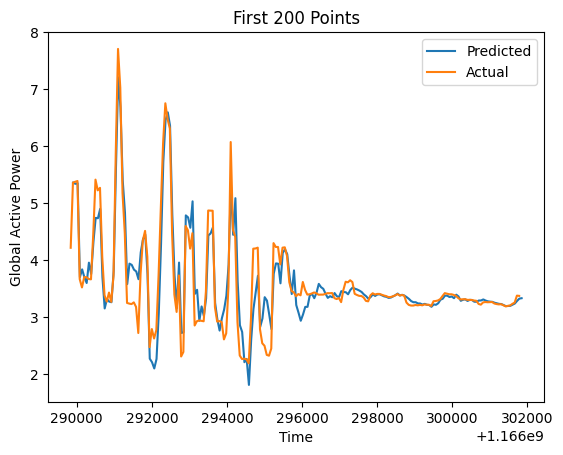

In [366]:
#Plot first 200 data points/predictions for the expanded dataset

fig, ax = plt.subplots()
ax.plot(tp_pred[:200], yp_pred[:200],  label='Predicted')
ax.plot(ts[:200], ys[:200],  label='Actual')
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')
ax.set_title('First 200 Points')
ax.legend()
plt.show()


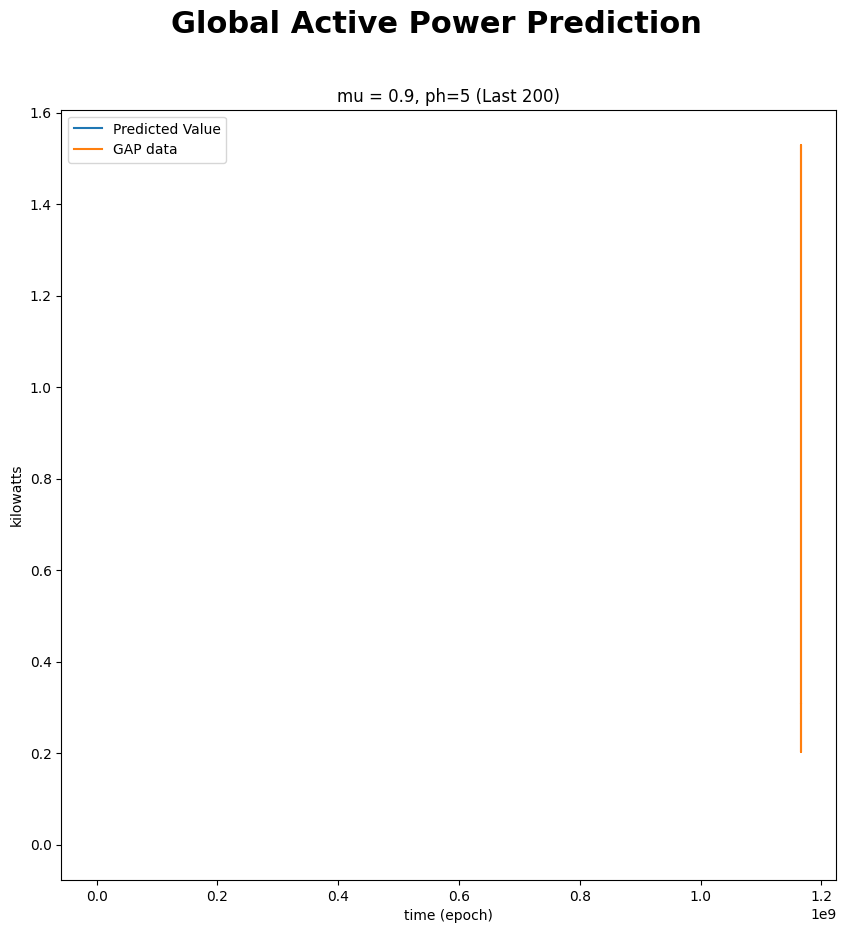

In [392]:
#Plot last 200 data points/predictions for the expanded data
fig, ax2 = plt.subplots(figsize=(10,10))

fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g (Last 200)' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 

# ax.plot(ts.iloc[n_s-300:n_s,0], ys.iloc[n_s-300:n_s,0], label='CGM data') 
# ax.plot(t_tot, hypoglycemiaTH, label='Hypoglycemia threshold')
ax2.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()
plt.show()

In [374]:
#Calculate MSE of predictions for the expanded data
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.5663709983189122


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: When voltage data was added to the model, the performance improved compared to the previous models. The MSE decreased from 1.414 and 0.59 for mu = 1 and mu = 0.01 models, respectively, to 0.566 for the new model with voltage data and mu = 0.9. This suggests that the voltage data is a useful predictor variable for the Global Active Power.The addition of voltage data likely improved the model because voltage and global active power are related, and voltage can affect power consumption. By including voltage data as a predictor variable in the linear regression model, we are able to capture this relationship and make more accurate predictions.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Here In this I have used moving window as a alternative model. It considers a fixed number of past data points to make a prediction for the next point. This differs from the previous model which considered all the past data points, giving equal weight to each of them.

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# Define rolling window size
n_w = 100

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1) 

# Iterate over the data points
for i in range(n_w, n_s):
    # Get the data within the rolling window
    ts_tmp = ts.iloc[i-n_w:i]
    ys_tmp = ys.iloc[i-n_w:i]
    
    # Fit a linear regression model on the data within the window
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)
    
    # Predict the target variable at the next time point
    tp = ts.iloc[i, 0] + ph
    yp = model_tmp.predict([[tp]])
      
    tp_pred[i-1] = tp    
    yp_pred[i-1] = yp




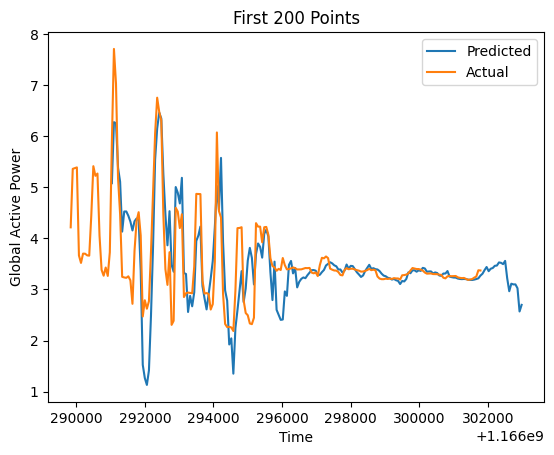

In [376]:
fig, ax = plt.subplots()
ax.plot(tp_pred[:200], yp_pred[:200],  label='Predicted')
ax.plot(ts[:200], ys[:200],  label='Actual')
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')
ax.set_title('First 200 Points')
ax.legend()
plt.show()


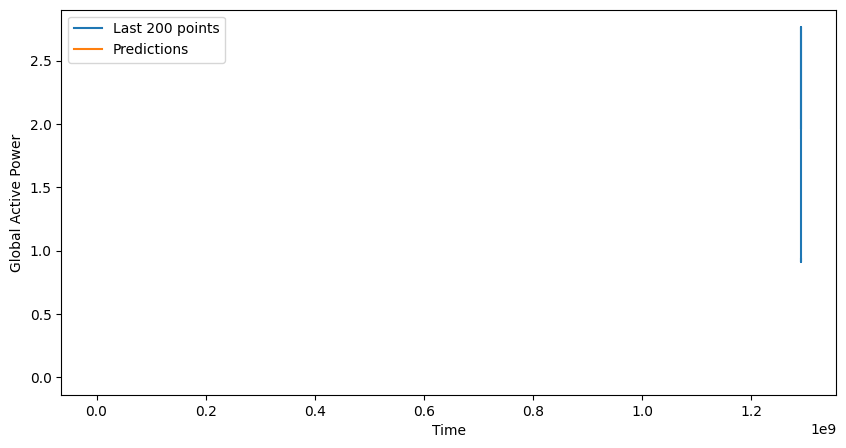

In [395]:
#Plot last 200 data points/predictions for alternative model

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df['unix'][-200:], df['Global_active_power'][-200:], label='Last 200 points')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predictions')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')
plt.show()


In [346]:
#Calculate MSE of predictions for alternative model
from sklearn.metrics import mean_squared_error as mse
print("MSE is", mse(ys['Global_active_power'][int(ph_index):int(5000+ph_index-1)],yp_pred))

MSE is 0.2279153150707153


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The rolling window model can be advantageous because it considers only a subset of the past data, which can help to avoid incorporating irrelevant information or outliers that could negatively impact the predictions. Additionally, the use of a rolling window can capture changes in the underlying patterns over time, which can help to improve the accuracy of the predictions.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.